In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(cowplot))
suppressMessages(library(R.utils))

In [2]:
suppressMessages(source("../lib/R/utils.R"))
suppressMessages(source("../lib/R/plots.R"))

In [3]:
options(jupyter.plot_scale = 1)

In [4]:
# Notebook inputs
c_data_dir <- get_var("DATA_DIR", default = "../data")
c_output_dir <- get_var("OUTPUT_DIR", default = "output")
c_selected_signatures <- as.vector(
  str_split(get_var("FITTING_REFERENCE_SIGNATURES", default = ""), ",", simplify = TRUE)
)
c_cosmic_genome <- get_var("COSMIC_GENOME", default = "GRCh38")
c_cosmic_version <- as.numeric(get_var("COSMIC_VERSION", default = 3.2))

c_snv_list <- glue::glue(c_data_dir, "/snv_list.csv")
c_signatures <- glue::glue(c_data_dir, "/signatures.csv")
c_contributions <- glue::glue(c_data_dir, "/contributions.csv")
c_extraction_stats <- glue::glue(c_data_dir, "/statistics.csv")
c_extra_signatures <- glue::glue(c_data_dir, "/extra_signatures.csv")

In [5]:
dir.create(glue::glue("{c_output_dir}/reconstruction/"), recursive = TRUE, showWarnings = FALSE)

In [6]:
# DELETE ME
c_selected_signatures <- c("SBS1", "SBS3", "SBS5", "SBS6", "SBS9", "SBS84")

In [7]:
# Load SNVs
df <- read.csv(c_snv_list, stringsAsFactors = FALSE) %>%
  dplyr::mutate(substitution = stringr::str_extract(mutation_type, ".>."))

# Mutational Signatures Analysis

## 1. RAW Mutation Counts

### 1.1. Mutational Profile

This is the representation of the RAW counts classified by substitution and context classified by group, useful to have a overall landscape of the distribution of the mutations (specially if the samples are clasiffied in different groups).
The "IG" groups corresponds to the mutations in the immunoglobulin loci.

In [8]:
# Make mutation tables for all snv and only ig ones
mutation_table_full <- make_mutation_table(df, group)

mutation_table_ig <-
  make_mutation_table(df %>% filter(ig == "True"), group) %>%
  dplyr::rename("IG CLL/MBL" = "CLL/MBL", "IG FL" = "FL")

# Combine mutation tables
mutation_table <-
  merge(mutation_table_full, mutation_table_ig, all = TRUE) %>%
  replace(is.na(.), 0)

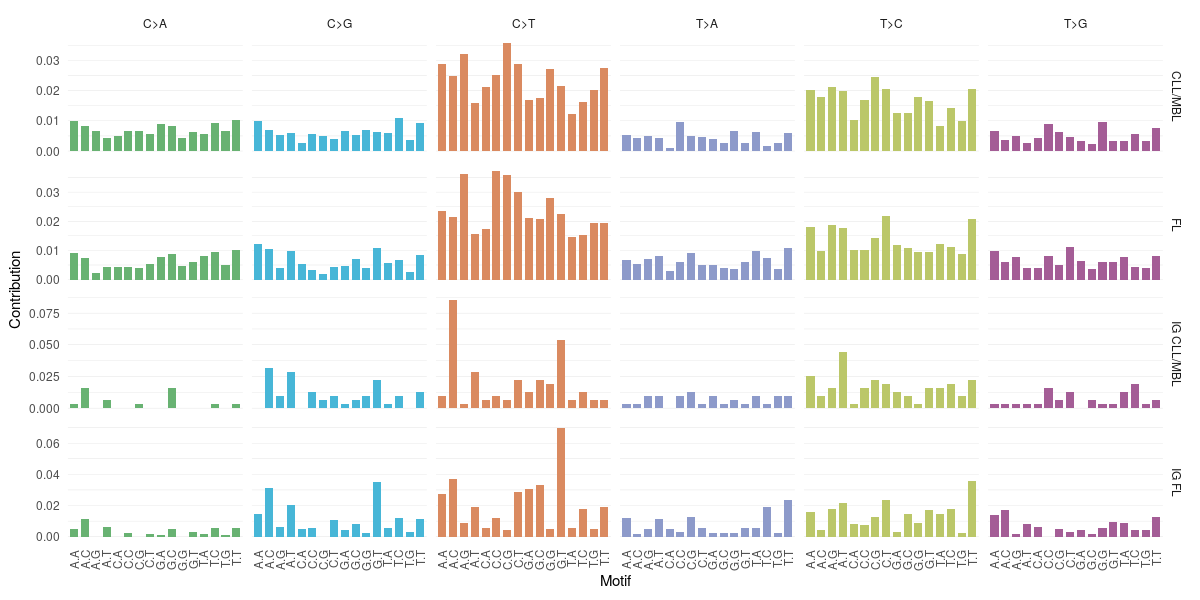

In [9]:
options(repr.plot.width = 10, repr.plot.height = 5)
print(plot_patterns_96(mutation_table))

### 1.2. AID Motifs

This figure represent the distribution of the mutations considering the AID-related described motifs. These are
- RCY, called canonical AID (cAID) motif. Normally expressed as a 4 nt motif; WRCY
- WAN (or WA), called non-canonical AID (nc-AID) [Kasar et al 2015]
- RCG, by signature 9 of COSMIC Mutational Signatures

*W = A or T, R = purine, Y = pyrimidine*

In [10]:
motif_table <- df %>%
    dplyr::count(group, ig, aid_pattern) %>%
    dplyr::mutate(
        aid_pattern = factor(replace(aid_pattern, aid_pattern == "", "None"), levels = c("RCY", "RCG", "WA", "None")),
        name = glue::glue("{ifelse(ig, 'IG', '')} {group}"),
    ) %>%
    dplyr::group_by(group, aid_pattern) %>%
    dplyr::mutate(n = ifelse(ig, n, sum(n))) %>%
    dplyr::group_by(name) %>%
    dplyr::mutate(perc = n / sum(n) * 100) %>%
    dplyr::ungroup() %>%
    dplyr::select(name, aid_pattern, n, perc) %>%
    dplyr::arrange(name, aid_pattern) %>%
    as.data.frame()

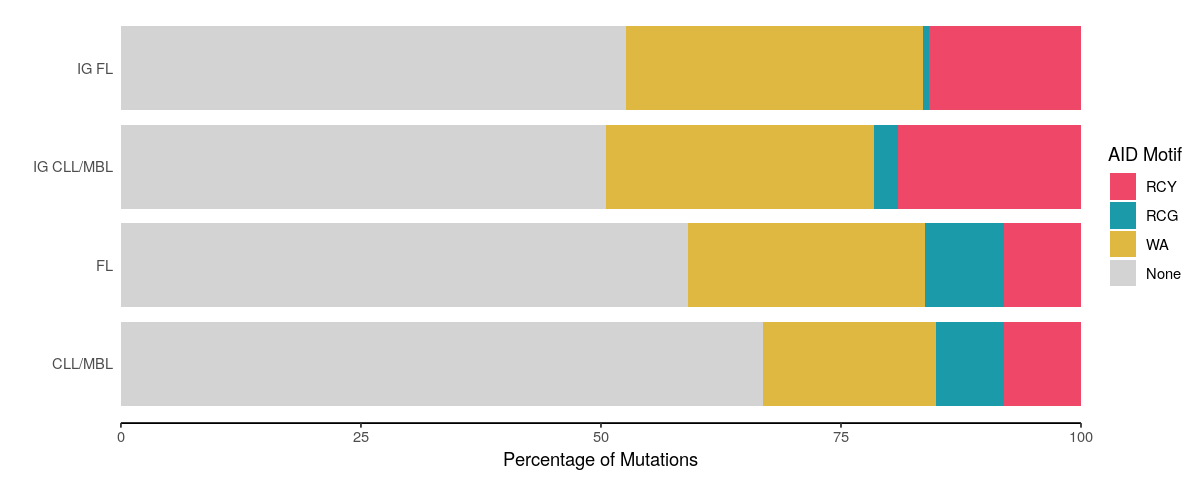

In [11]:
options(repr.plot.width = 10, repr.plot.height = 4)
print(plot_aid_motifs(motif_table))

## 2. Signature Extraction

The extraction of signatures is a process that tries to decompose the complete mutational profile in multiple signals, each one corresponding a different underlying mutational procsess.

Signature extraction is performed by [SigProfiler](https://github.com/AlexandrovLab/SigProfilerExtractor), considered the reference method at the moment.

### 2.1. Extraction Statistics

SigProfiler collects two metrics for each number of signatures extracted, these are:
- Average stability: the mean of the silhouettes for each signature cluster (produced by the multiple iterations of the factorization)
- Mean cosine distance: the mean of the cosine distances between the original values for each sample and the reconstructed ones by Non-Negative Matrix Factorization

SigProfiler automatically select an optimal number of singatures using these scores (this value is marked with an *).

In [12]:
# Read extraction stats
extraction_stats <- read.csv(c_extraction_stats, stringsAsFactors = FALSE)

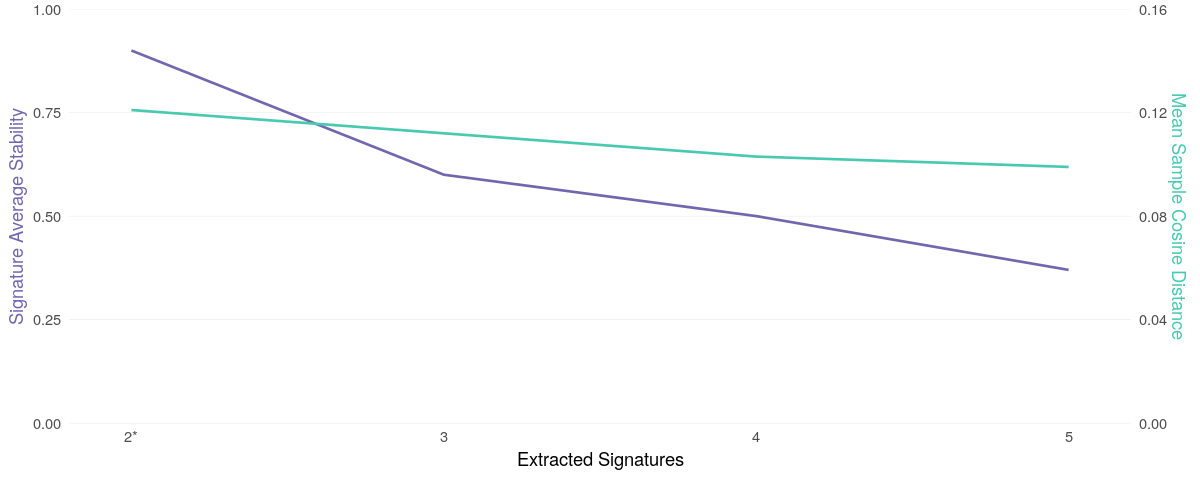

In [13]:
options(repr.plot.width = 10, repr.plot.height = 4)
print(plot_extraction_statistics(extraction_stats))

### 2.2. Signatures

If the parameter to force a number of signatures was used, the recommendation of SigProfiler will be ignored and the number of signatures displayed will not match the highlighted number displayed in the previous plot.

In [14]:
# load signatures
signatures <- read.csv(c_signatures) %>%
  dplyr::mutate(X = sub("^(.)\\[(.>.)\\](.)$", "\\2 \\1.\\3", mutation)) %>%
  tidyr::separate(X, c("substitution", "context"), " ") %>%
  dplyr::select(substitution, context, everything(), -mutation)

contributions <- read.csv(c_contributions) %>%
  tidyr::gather("signature", "contribution", -sample) %>%
  dplyr::group_by(sample) %>%
  dplyr::mutate(contribution = contribution / sum(contribution))

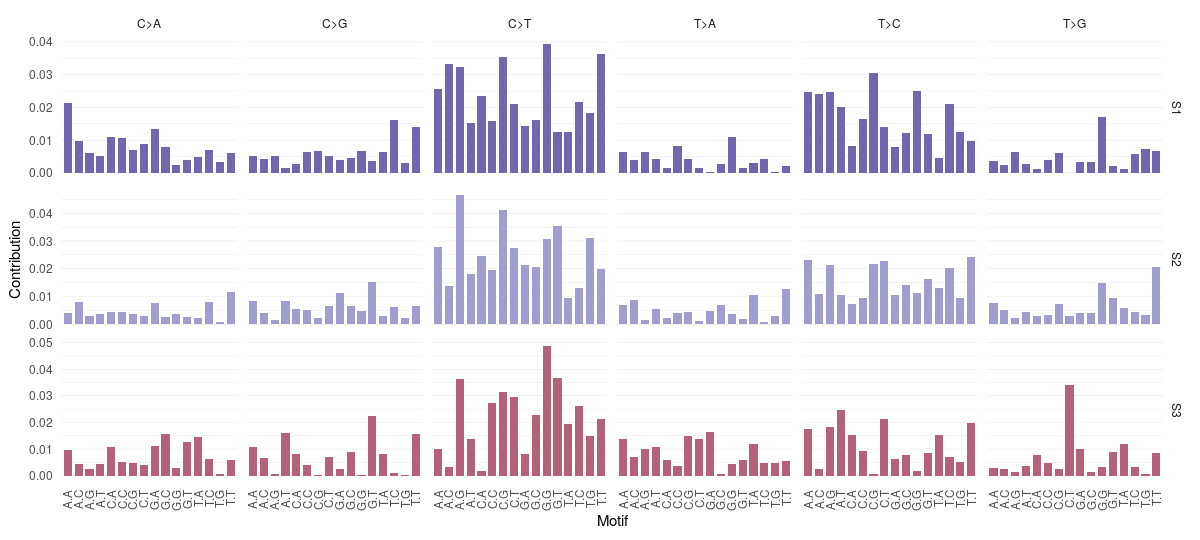

In [15]:
options(repr.plot.width = 10, repr.plot.height = (ncol(signatures) - 2) * 1.5)
print(plot_patterns_96(signatures, colorby = "sample"))

### 2.3. Signature Contribution

This plot shows how each signature contributes to the mutations present in each sample.

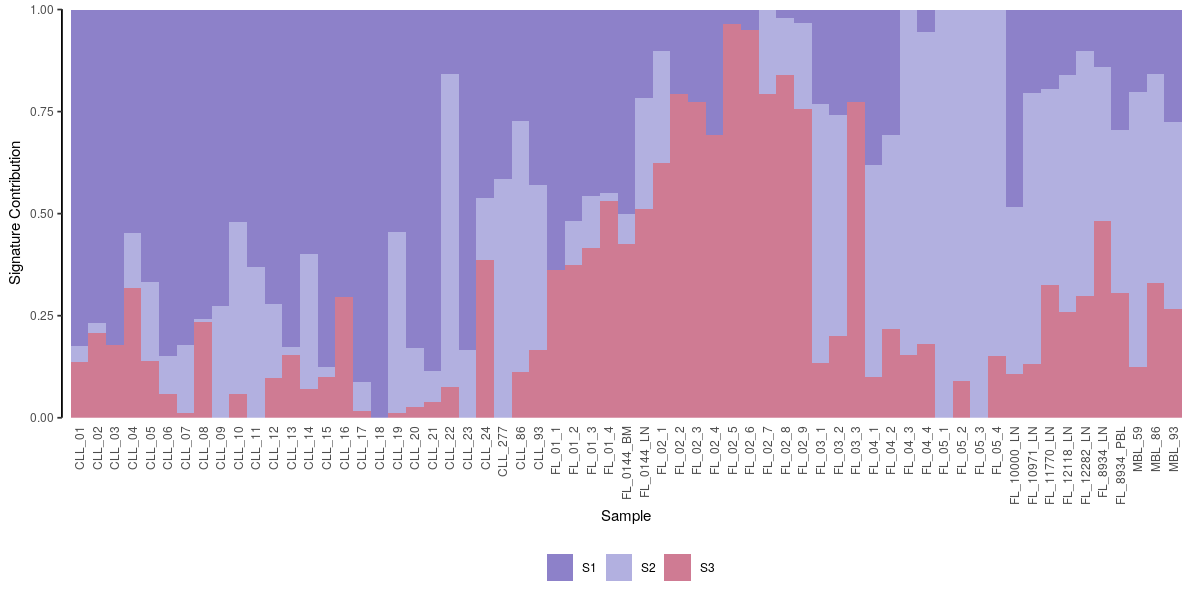

In [16]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot_signature_contributions(contributions, from_extraction = TRUE)

## 3. Comparison Against Reference Signatures

### 3.1. Signature Reconstruction

The reconstruction tries to explain the *denovo* extracted signatures using reference signatures.

For this purpose each signature is tested against a combination of multiple reference signatures (2 in this case), using a Non Negative Least Squares (NNLS) optimization to find the optimal coefficients. Then, the reconstruction is compared to the original signal using cosine similarity.

In [17]:
signatures_cosmic <- get_cosmic_signatures(version = c_cosmic_version, genome = c_cosmic_genome)

In [18]:
for (s in names(signatures) %>% purrr::discard(~ . %in% c("substitution", "context", "mutation"))) {
  reconstruction <- reconstruct_signatures(signatures[[s]], signatures_cosmic)

  # print top hits
  print(glue::glue("Top combinations {s}:"))
  print(head(reconstruction))
  cat("\n")

  # save full list
  write.csv(reconstruction, glue::glue("{c_output_dir}/reconstruction/{s}.csv"), row.names = FALSE)
}

Top combinations S1:
        name          proportions        similarity
1  SBS1+SBS5    SBS1=0.1;SBS5=0.9 0.909690780376019
2  SBS5+SBS6  SBS5=0.85;SBS6=0.15 0.895632282240556
3 SBS5+SBS87 SBS5=0.85;SBS87=0.15 0.890132791935488
4 SBS5+SBS15   SBS5=0.9;SBS15=0.1 0.882961739312502
5 SBS5+SBS51   SBS5=0.9;SBS51=0.1 0.865175942076502
6 SBS5+SBS50 SBS5=0.91;SBS50=0.09 0.865009395965459

Top combinations S2:
        name          proportions        similarity
1  SBS1+SBS5  SBS1=0.13;SBS5=0.87 0.924086794655936
2  SBS5+SBS6  SBS5=0.79;SBS6=0.21  0.91202900826912
3 SBS5+SBS87   SBS5=0.8;SBS87=0.2 0.898147728919978
4 SBS5+SBS15 SBS5=0.88;SBS15=0.12 0.870098572527607
5  SBS3+SBS6  SBS3=0.72;SBS6=0.28 0.867176950762029
6 SBS6+SBS40   SBS6=0.3;SBS40=0.7 0.864468973789573

Top combinations S3:
        name          proportions        similarity
1 SBS6+SBS40 SBS6=0.26;SBS40=0.74 0.843922793186727
2 SBS5+SBS15 SBS5=0.82;SBS15=0.18 0.843151059490169
3  SBS1+SBS5  SBS1=0.12;SBS5=0.88 0.839547739065988

### 3.2. Sample Fitting

The fitting process tries to explain the mutations present in each sample but using a given set of reference signatures, not denovo ones.

This process is performed by [deconstructSigs](https://github.com/raerose01/deconstructSigs).

In [19]:
# if selected signatures is empty, use all of them
if (c_selected_signatures == "" || length(c_selected_signatures) == 0) {
  c_selected_signatures <- colnames(signatures_cosmic) %>%
    purrr::discard(~ . %in% c("mutation", "substitution", "context"))
}

fitting_signatures <- signatures_cosmic %>%
  dplyr::select(mutation, substitution, context, dplyr::one_of(c_selected_signatures))

# load extra signatures
if (isFile(c_extra_signatures)) {
    extra_signatures <- read.csv(c_extra_signatures)
    fitting_signatures <- fitting_signatures %>% left_join(extra_signatures, by="mutation")
}

mutational_matrix <- df %>%
  make_mutation_table(sample) %>%
  dplyr::mutate(mutation = format_mutation(substitution, context))

In [20]:
fitting_table <- fit_signatures(mutational_matrix, fitting_signatures)
write.csv(fitting_table %>% spread(signature, contribution), glue::glue("{c_output_dir}/fitting.csv"), row.names = FALSE)

In [21]:
# make hierarchical cluster using DIANA
fitting_hclust <- fitting_clustering(fitting_table)
# reorder samples according to clustering result
fitting_table <- fitting_table %>%
  dplyr::mutate(sample = factor(sample, levels = fitting_hclust$order.lab))

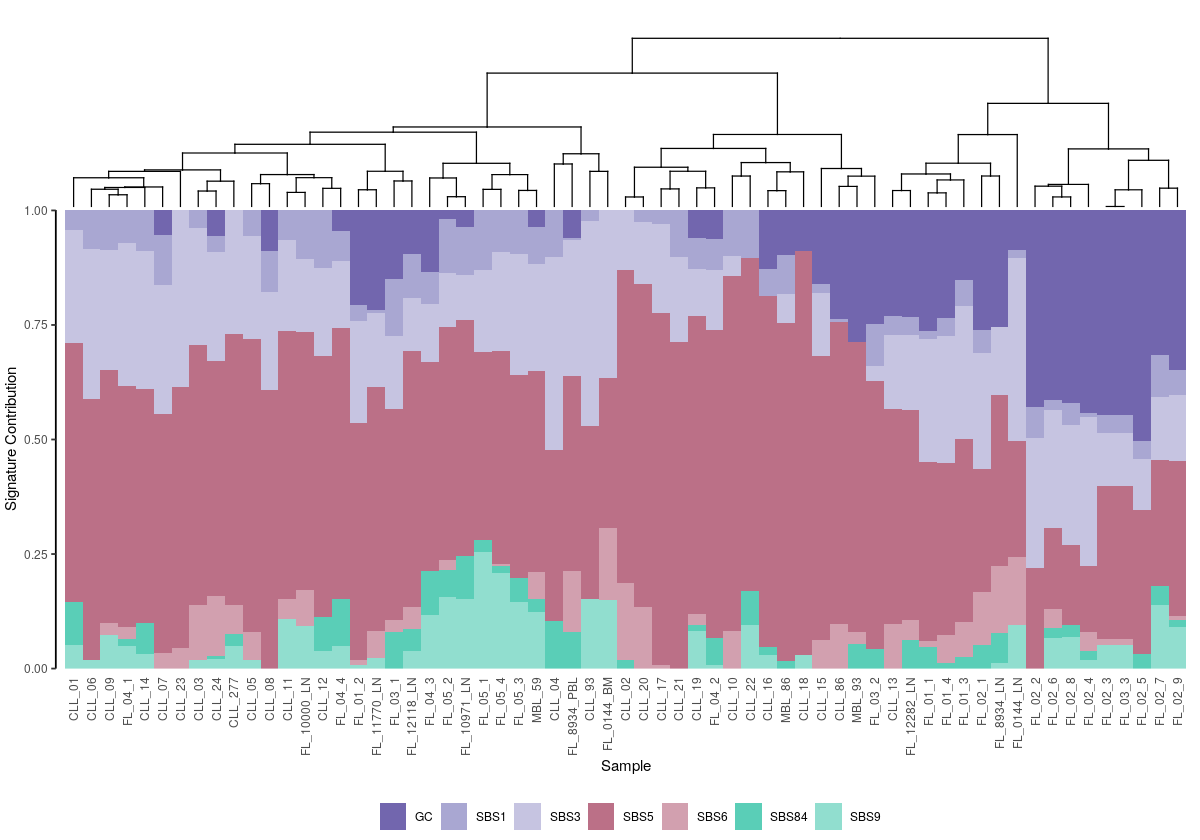

In [22]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot_fitting_dend <- plot_hclust(fitting_hclust)
plot_fitting_contrib <- plot_signature_contributions(fitting_table, from_extraction = FALSE) + theme(plot.margin = unit(c(0, 1, 0, 1), "mm"))
plot_merged <- plot_grid(plot_fitting_dend, plot_fitting_contrib, nrow = 2, rel_heights = c(1, 3), align = "v", axis = "lr")
print(plot_merged)